In [1]:
import os
from datetime import datetime
import numpy as np

from stable_baselines3 import PPO
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.vec_env import DummyVecEnv
from cityflow_env import CityFlowEnv


In [2]:
# ---------------------- Basic paths and settings ----------------------

config_path = "examples/config.json"   # make sure this points to your CityFlow config
log_dir = "sb3_logs/ppo_cityflow"
os.makedirs(log_dir, exist_ok=True)

model_save_path = os.path.join(log_dir, "ppo_cityflow_model")
tensorboard_log = os.path.join(log_dir, "tb")

# number of parallel environments (start with 1 to be safe)
n_envs = 1


In [3]:
# ------------- Make a function that creates one CityFlow env -------------
def make_env(config_path: str, log_dir: str):
    """
    Factory function to create a single CityFlowEnv instance
    wrapped with Monitor to record episode rewards and lengths.
    """
    def _init():
        env = CityFlowEnv(config_path)
        # CSV file path
        monitor_path = os.path.join(log_dir, "monitor.csv")   
        env = Monitor(env, filename=monitor_path)
        return env
    return _init

In [4]:
# ---------------------- Create vectorized environment -----------------

# DummyVecEnv is used for single- or multi-env setup
env_fns = [make_env(config_path, log_dir) for _ in range(n_envs)]
vec_env = DummyVecEnv(env_fns)

Loading file: examples/config.json
Successfully initialize environment: watch the crossing intersection_1_1, focus on 28


In [5]:
# ---------------------- Create PPO model (SB3) ------------------------

"""
MlpPolicy: a simple feed-forward neural network (MLP).
You can tune the policy_kwargs for deeper/wider networks if needed.
"""

model = PPO(
    policy="MlpPolicy",
    env=vec_env,
    learning_rate=5e-5,
    n_steps=2048,          # how many steps to collect per PPO update
    batch_size=64,
    n_epochs=10,          # mini-batch updates per PPO epoch
    gamma=0.99,
    gae_lambda=0.95,
    clip_range=0.2,
    verbose=1,
    tensorboard_log=tensorboard_log,
    device="cpu",
)

Using cpu device


In [6]:
# ---------------------- Train the model -------------------------------

total_timesteps = int(7e4)

start_time = datetime.now().replace(microsecond=0)
print("===============================================================")
print("Start training at:", start_time)
print("Total timesteps:", total_timesteps)
print("Logs dir:", log_dir)
print("===============================================================")

model.learn(
    total_timesteps=total_timesteps,
    tb_log_name="PPO_CityFlow",
    progress_bar=True
)

end_time = datetime.now().replace(microsecond=0)
print("===============================================================")
print("Finished training at:", end_time)
print("Total training time:", end_time - start_time)
print("===============================================================")


Start training at: 2025-12-15 04:09:31
Total timesteps: 70000
Logs dir: sb3_logs/ppo_cityflow
Logging to sb3_logs/ppo_cityflow/tb/PPO_CityFlow_22


Output()

----------------------------------
| rollout/           |           |
|    ep_len_mean     | 360       |
|    ep_rew_mean     | -2.18e+03 |
| time/              |           |
|    fps             | 181       |
|    iterations      | 1         |
|    time_elapsed    | 11        |
|    total_timesteps | 2048      |
----------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 360          |
|    ep_rew_mean          | -2.1e+03     |
| time/                   |              |
|    fps                  | 129          |
|    iterations           | 2            |
|    time_elapsed         | 31           |
|    total_timesteps      | 4096         |
| train/                  |              |
|    approx_kl            | 0.0082335295 |
|    clip_fraction        | 0.0105       |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.08        |
|    explained_variance   | 0.0122       |
|    

Finished training at: 2025-12-15 04:18:02
Total training time: 0:08:31


In [8]:
# ---------------------- Save trained model ----------------------------

model.save(model_save_path)
print(f"Model saved to: {model_save_path}")

Model saved to: sb3_logs/ppo_cityflow/ppo_cityflow_model


In [10]:
import numpy as np

# ---------------------- PPO Evaluation ----------------------
# Evaluate the trained PPO model using deterministic actions
# Metrics:
#   - Episodic reward
#   - Average waiting vehicles per decision step (aligned with DQN)

eval_episodes = 10
env = CityFlowEnv(config_path)

episode_rewards = []
episode_avg_waitings = []

for ep in range(eval_episodes):
    # Reset environment (Gymnasium-compatible)
    reset_out = env.reset()
    state = reset_out[0] if isinstance(reset_out, tuple) else reset_out

    done = False
    ep_reward = 0.0
    step_count = 0

    # Accumulator for average waiting vehicles per step
    sum_avg_waiting = 0.0

    while not done:
        # Select action using the trained PPO policy (no exploration)
        action, _ = model.predict(state, deterministic=True)

        step_out = env.step(action)

        # Support both Gymnasium and Gym return formats
        if len(step_out) == 5:
            next_state, reward, terminated, truncated, info = step_out
            done = terminated or truncated
        else:
            next_state, reward, done, info = step_out

        # Accumulate episodic reward
        ep_reward += reward
        step_count += 1
        state = next_state

        # ---------------- Average Waiting Vehicles ----------------
        # Get the number of waiting vehicles on each observed lane
        lane_wait = env.eng.get_lane_waiting_vehicle_count()

        # Total waiting vehicles over all observed lanes
        total_wait = sum(lane_wait.get(lane, 0) for lane in env.start_lane_ids)

        # Average waiting vehicles per lane (aligned with DQN definition)
        avg_wait = total_wait / len(env.start_lane_ids)

        # Accumulate per-step average waiting vehicles
        sum_avg_waiting += avg_wait

    # Average waiting vehicles per decision step in this episode
    ep_avg_waiting = sum_avg_waiting / step_count

    episode_rewards.append(ep_reward)
    episode_avg_waitings.append(ep_avg_waiting)

    print(
        f"Test Episode {ep+1}: "
        f"Reward = {ep_reward:.2f}, "
        f"Avg Waiting = {ep_avg_waiting:.2f}"
    )

env.close()

# ---------------------- Evaluation Summary ----------------------
print("\nTest Results Summary:")
print(
    f"Average Reward: "
    f"{np.mean(episode_rewards):.2f} ± {np.std(episode_rewards):.2f}"
)
print(
    f"Average Waiting Vehicles: "
    f"{np.mean(episode_avg_waitings):.2f} ± {np.std(episode_avg_waitings):.2f}"
)


Loading file: examples/config.json
Successfully initialize environment: watch the crossing intersection_1_1, focus on 28
Test Episode 1: Reward = -658.00, Avg Waiting = 23.97
Test Episode 2: Reward = -657.00, Avg Waiting = 23.97
Test Episode 3: Reward = -657.50, Avg Waiting = 23.96
Test Episode 4: Reward = -657.60, Avg Waiting = 23.98
Test Episode 5: Reward = -656.70, Avg Waiting = 23.95
Test Episode 6: Reward = -658.20, Avg Waiting = 23.97
Test Episode 7: Reward = -656.40, Avg Waiting = 23.95
Test Episode 8: Reward = -656.20, Avg Waiting = 23.97
Test Episode 9: Reward = -656.30, Avg Waiting = 23.96
Test Episode 10: Reward = -657.40, Avg Waiting = 23.97

Test Results Summary:
Average Reward: -657.13 ± 0.68
Average Waiting Vehicles: 23.96 ± 0.01


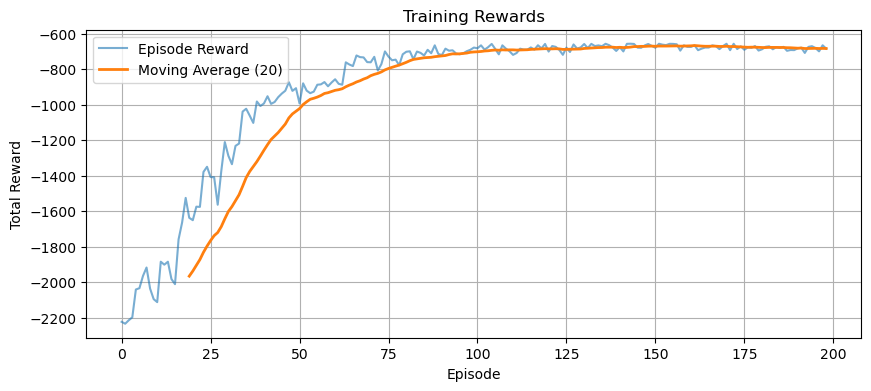

In [11]:
import pandas as pd
import matplotlib.pyplot as plt

# Path to the Monitor CSV file
monitor_path = os.path.join(log_dir, "monitor.csv")

# Skip the first row because it contains comments
df = pd.read_csv(monitor_path, skiprows=1)

# Episode rewards
rewards = df["r"].to_numpy()

# Moving average window
window = 20
moving_avg = pd.Series(rewards).rolling(window).mean()

# Plot rewards
plt.figure(figsize=(10, 4))
plt.plot(rewards, label="Episode Reward", alpha=0.6)
plt.plot(moving_avg, label=f"Moving Average ({window})", linewidth=2)
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("Training Rewards")
plt.legend()
plt.grid(True)
plt.show()


Using event file: sb3_logs/ppo_cityflow/tb/PPO_CityFlow_22/events.out.tfevents.1765789771.localhost.26335.0
Available scalar tags:
['rollout/ep_len_mean', 'rollout/ep_rew_mean', 'time/fps', 'train/approx_kl', 'train/clip_fraction', 'train/clip_range', 'train/entropy_loss', 'train/explained_variance', 'train/learning_rate', 'train/loss', 'train/policy_gradient_loss', 'train/value_loss']


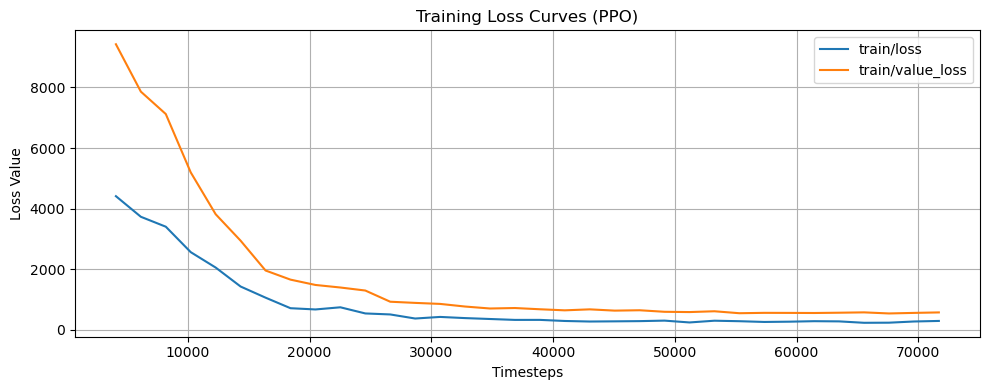

In [12]:
import os
import glob
import matplotlib.pyplot as plt
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator

# Find TensorBoard event files
event_files = glob.glob(
    os.path.join(tensorboard_log, "**", "events.out.tfevents.*"),
    recursive=True
)

assert len(event_files) > 0, "No TensorBoard event files found."

# Use the latest event file
event_file = sorted(event_files, key=os.path.getmtime)[-1]
print("Using event file:", event_file)

# Load TensorBoard events
ea = EventAccumulator(event_file)
ea.Reload()

# Print available scalar tags
print("Available scalar tags:")
print(ea.Tags()["scalars"])

# Keep only meaningful PPO losses
loss_tags = [
    "train/loss",
    "train/value_loss",
]

# Keep only existing tags (safe for different SB3 versions)
loss_tags = [tag for tag in loss_tags if tag in ea.Tags()["scalars"]]
assert len(loss_tags) > 0, "No loss-related tags found."

# Plot
plt.figure(figsize=(10, 4))
for tag in loss_tags:
    events = ea.Scalars(tag)
    steps = [e.step for e in events]
    values = [e.value for e in events]
    plt.plot(steps, values, label=tag)

plt.xlabel("Timesteps")
plt.ylabel("Loss Value")
plt.title("Training Loss Curves (PPO)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
